## Modelagem - Predição usando Regressão Logística e Random Forest

In [1]:
# Bibliotecas
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

In [25]:
df_limpo= pd.read_csv("dados/df_limpo_modelagem.csv")


print(df_limpo.isnull().sum())
print(df_limpo.isnull().sum())


tenure                      0
PhoneService                0
MultipleLines               0
InternetService             0
OnlineSecurity              0
OnlineBackup                0
DeviceProtection            0
TechSupport                 0
StreamingTV                 0
StreamingMovies             0
Contract                    0
PaperlessBilling            0
PaymentMethod               0
MonthlyCharges              0
TotalCharges                0
Churn                       0
cpf                         0
NPS                         0
gender                      0
SeniorCitizen               0
Partner                     0
Dependents                  0
churn_bin                   0
TotalServicosContratados    0
dtype: int64
tenure                      0
PhoneService                0
MultipleLines               0
InternetService             0
OnlineSecurity              0
OnlineBackup                0
DeviceProtection            0
TechSupport                 0
StreamingTV                

In [4]:
df_limpo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7034 entries, 0 to 7033
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   tenure                    7034 non-null   int64  
 1   PhoneService              7034 non-null   object 
 2   MultipleLines             7034 non-null   object 
 3   InternetService           7034 non-null   object 
 4   OnlineSecurity            7034 non-null   object 
 5   OnlineBackup              7034 non-null   object 
 6   DeviceProtection          7034 non-null   object 
 7   TechSupport               7034 non-null   object 
 8   StreamingTV               7034 non-null   object 
 9   StreamingMovies           7034 non-null   object 
 10  Contract                  7034 non-null   object 
 11  PaperlessBilling          7034 non-null   object 
 12  PaymentMethod             7034 non-null   object 
 13  MonthlyCharges            7034 non-null   float64
 14  TotalCha

In [5]:
# Variável alvo
y = df_limpo["churn_bin"]

# Remove colunas que não fazem sentido como preditoras diretas
drop_cols = ["Churn", "cpf", "churn_bin"]  

X = df_limpo.drop(columns=drop_cols)

# Separar numéricas e categóricas
numeric_features = ["tenure", "MonthlyCharges", "TotalCharges", "NPS", 
                    "SeniorCitizen", "TotalServicosContratados"]

categorical_features = [col for col in X.columns if col not in numeric_features]


In [6]:
# Pré-processamento: padroniza numéricas e faz OneHot em categóricas
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ])


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


In [8]:
# Pipeline Regressão Logística
lr_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, random_state=42))
])

lr_pipeline.fit(X_train, y_train)

y_pred_lr = lr_pipeline.predict(X_test)
y_proba_lr = lr_pipeline.predict_proba(X_test)[:, 1]

print("=== Regressão Logística ===")
print(classification_report(y_test, y_pred_lr))
print("Acurácia:", accuracy_score(y_test, y_pred_lr))
print("AUC-ROC:", roc_auc_score(y_test, y_proba_lr))


=== Regressão Logística ===
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1550
           1       0.67      0.57      0.61       561

    accuracy                           0.81      2111
   macro avg       0.76      0.73      0.74      2111
weighted avg       0.80      0.81      0.81      2111

Acurácia: 0.8105163429654192
AUC-ROC: 0.8468880455407968


In [9]:
# Pipeline Random Forest
rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=200, random_state=42))
])

rf_pipeline.fit(X_train, y_train)

y_pred_rf = rf_pipeline.predict(X_test)
y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

print("\n=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))
print("Acurácia:", accuracy_score(y_test, y_pred_rf))
print("AUC-ROC:", roc_auc_score(y_test, y_proba_rf))



=== Random Forest ===
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1550
           1       0.64      0.49      0.55       561

    accuracy                           0.79      2111
   macro avg       0.73      0.69      0.71      2111
weighted avg       0.78      0.79      0.78      2111

Acurácia: 0.7901468498342018
AUC-ROC: 0.8224593180380657


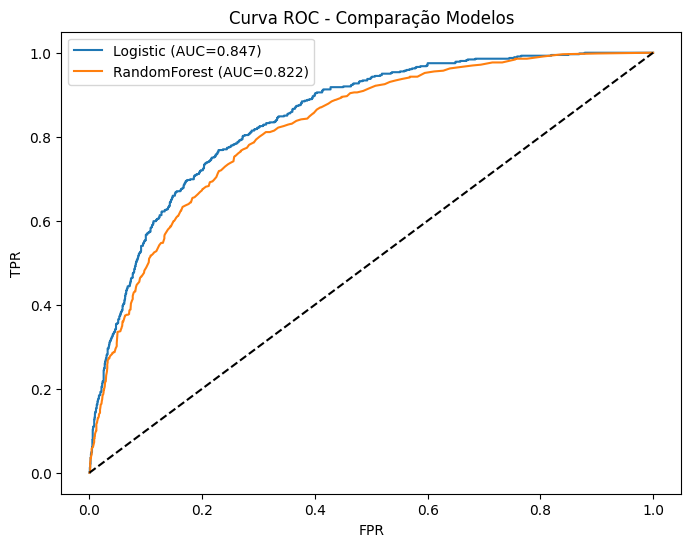

In [15]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8,6))

# Logistic
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
plt.plot(fpr_lr, tpr_lr, label=f"Logistic (AUC={auc(fpr_lr, tpr_lr):.3f})")

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
plt.plot(fpr_rf, tpr_rf, label=f"RandomForest (AUC={auc(fpr_rf, tpr_rf):.3f})")

# Linha base
plt.plot([0,1],[0,1],"k--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curva ROC - Comparação Modelos")
plt.legend()
plt.show()


Treinando Regressão Logística...
Treinando Random Forest...

=== Regressão Logística ===
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      1550
           1       0.53      0.77      0.63       561

    accuracy                           0.76      2111
   macro avg       0.72      0.76      0.73      2111
weighted avg       0.80      0.76      0.77      2111

AUC-ROC: 0.8466


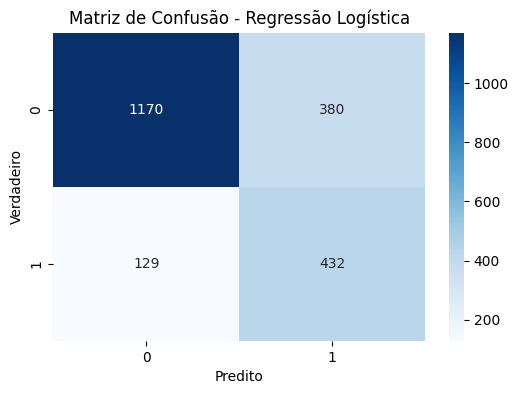


=== Random Forest ===
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      1550
           1       0.58      0.70      0.63       561

    accuracy                           0.79      2111
   macro avg       0.73      0.76      0.74      2111
weighted avg       0.80      0.79      0.79      2111

AUC-ROC: 0.8407


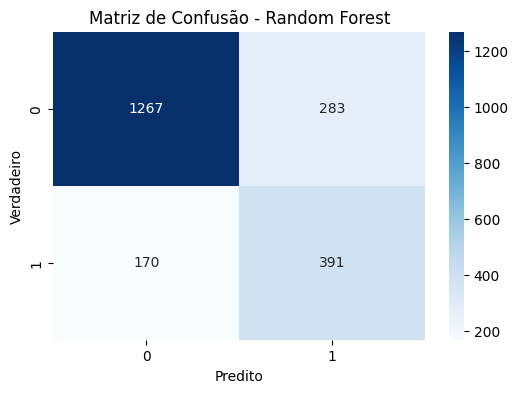


=== FEATURES SELECIONADAS ===
Regressão Logística selecionou 24 features:
['tenure' 'MonthlyCharges' 'TotalCharges' 'NPS' 'SeniorCitizen'
 'TotalServicosContratados' 'InternetService_Fiber optic'
 'OnlineSecurity_No' 'OnlineBackup_No' 'DeviceProtection_No'
 'TechSupport_No' 'Contract_Month-to-month' 'Contract_One year'
 'Contract_Two year' 'PaperlessBilling_No' 'PaperlessBilling_Yes'
 'PaymentMethod_Credit card (automatic)' 'PaymentMethod_Electronic check'
 'gender_Female' 'gender_Male' 'Partner_No' 'Partner_Yes' 'Dependents_No'
 'Dependents_Yes']

Random Forest selecionou 24 features:
['tenure' 'MonthlyCharges' 'TotalCharges' 'NPS' 'SeniorCitizen'
 'TotalServicosContratados' 'InternetService_Fiber optic'
 'OnlineSecurity_No' 'OnlineBackup_No' 'DeviceProtection_No'
 'TechSupport_No' 'Contract_Month-to-month' 'Contract_One year'
 'Contract_Two year' 'PaperlessBilling_No' 'PaperlessBilling_Yes'
 'PaymentMethod_Credit card (automatic)' 'PaymentMethod_Electronic check'
 'gender_Female' 'g

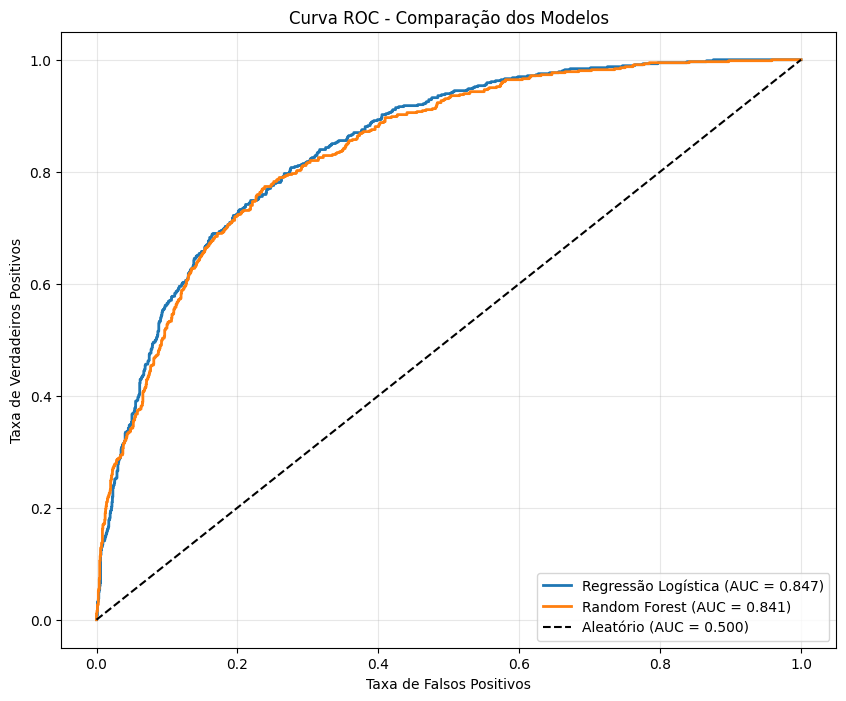

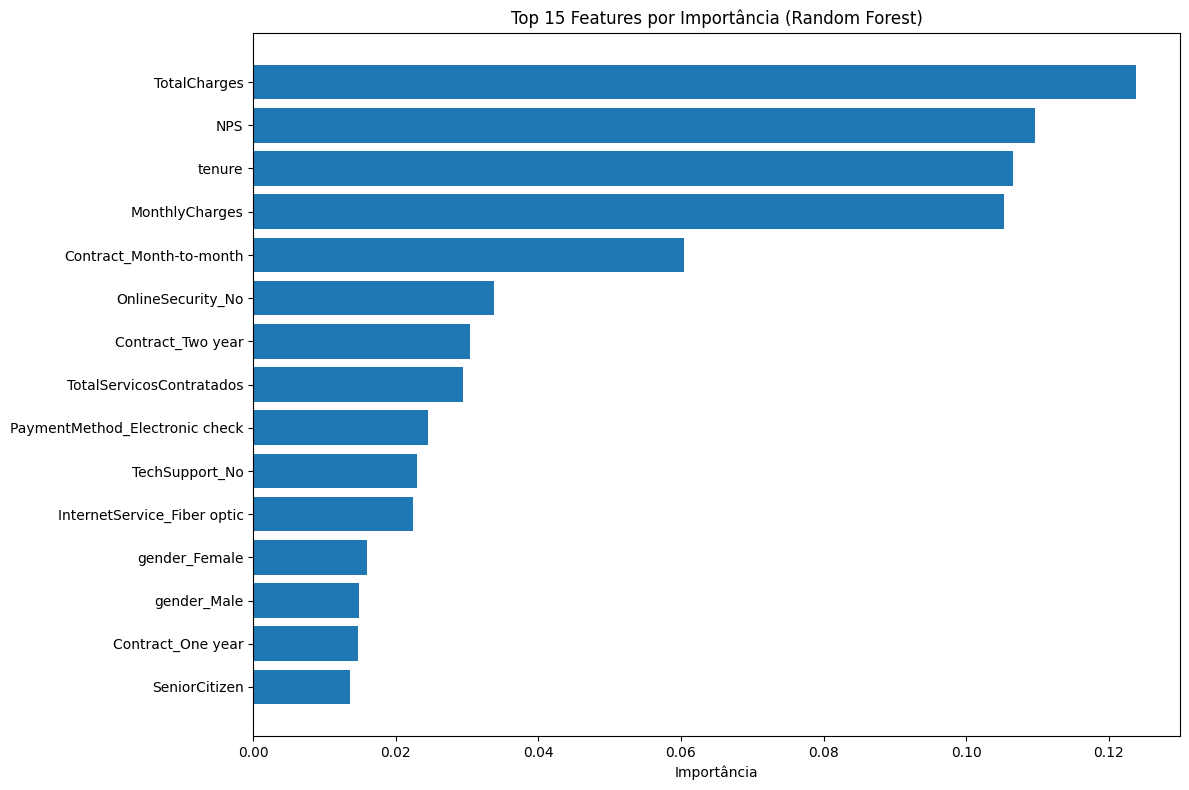

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
df = df_limpo.copy()

# 1. Dados
X = df.drop(['churn_bin', 'Churn', 'cpf'], axis=1)
y = df['churn_bin']

# 2. Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 3. Definir colunas numéricas e categóricas
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'NPS','SeniorCitizen', 'TotalServicosContratados']
categorical_features = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 
                       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 
                       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
                       'gender', 'Partner', 'Dependents']

# 4. Pré-processamento (comum para ambos os modelos)
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# 5. PIPELINE PARA REGRESSÃO LOGÍSTICA
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', SelectFromModel(
        RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
        threshold='median')),  # Seleciona features acima da mediana de importância
    ('classifier', LogisticRegression(
        max_iter=1000, 
        random_state=42, 
        class_weight='balanced',
        solver='liblinear'))
])

# 6. PIPELINE PARA RANDOM FOREST
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', SelectFromModel(
        RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
        threshold='median')),
    ('classifier', RandomForestClassifier(
        n_estimators=200, 
        random_state=42, 
        class_weight='balanced',
        max_depth=10))
])

# 7. Treinar ambos os modelos
print("Treinando Regressão Logística...")
lr_pipeline.fit(X_train, y_train)

print("Treinando Random Forest...")
rf_pipeline.fit(X_train, y_train)

# 8. Avaliar os modelos
def evaluate_model(model, model_name, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print(f"\n=== {model_name} ===")
    print("Relatório de Classificação:")
    print(classification_report(y_test, y_pred))
    print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")
    
    # Matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.ylabel('Verdadeiro')
    plt.xlabel('Predito')
    plt.show()
    
    return y_proba

# Avaliar ambos os modelos
y_proba_lr = evaluate_model(lr_pipeline, "Regressão Logística", X_test, y_test)
y_proba_rf = evaluate_model(rf_pipeline, "Random Forest", X_test, y_test)

# 9. Comparar as features selecionadas por cada modelo
def get_selected_features(pipeline, categorical_features, numeric_features):
    # Obter nomes das features após one-hot
    onehot_columns = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
    all_features = numeric_features + list(onehot_columns)
    
    # Obter máscara de features selecionadas
    selected_mask = pipeline.named_steps['feature_selector'].get_support()
    selected_features = np.array(all_features)[selected_mask]
    
    return selected_features

# Features selecionadas
lr_features = get_selected_features(lr_pipeline, categorical_features, numeric_features)
rf_features = get_selected_features(rf_pipeline, categorical_features, numeric_features)

print("\n=== FEATURES SELECIONADAS ===")
print(f"Regressão Logística selecionou {len(lr_features)} features:")
print(lr_features)

print(f"\nRandom Forest selecionou {len(rf_features)} features:")
print(rf_features)

# Features em comum
common_features = set(lr_features) & set(rf_features)
print(f"\nFeatures em comum entre os modelos: {len(common_features)}")
print(common_features)

# 10. Curva ROC comparativa
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))

# Curva ROC Regressão Logística
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, label=f'Regressão Logística (AUC = {roc_auc_lr:.3f})', linewidth=2)

# Curva ROC Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.3f})', linewidth=2)

# Linha de referência
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório (AUC = 0.500)')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Comparação dos Modelos')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

# 11. Importância das features (apenas para Random Forest)
rf_importances = rf_pipeline.named_steps['feature_selector'].estimator_.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': numeric_features + list(rf_pipeline.named_steps['preprocessor']
                                    .named_transformers_['cat']
                                    .named_steps['onehot']
                                    .get_feature_names_out(categorical_features)),
    'Importance': rf_importances
})

feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'][:15], feature_importance_df['Importance'][:15])
plt.title('Top 15 Features por Importância (Random Forest)')
plt.xlabel('Importância')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [27]:
# F1-Score, Precisão, Recall para cada modelo
from sklearn.metrics import f1_score, precision_score, recall_score

print("F1-Score LR:", f1_score(y_test, y_pred_lr))
print("F1-Score RF:", f1_score(y_test, y_pred_rf))
print("Precisão LR:", precision_score(y_test, y_pred_lr))
print("Precisão RF:", precision_score(y_test, y_pred_rf))

F1-Score LR: 0.6138996138996139
F1-Score RF: 0.5529767911200807
Precisão LR: 0.6694736842105263
Precisão RF: 0.6372093023255814


Com base nas novas métricas, a Regressão Logística é claramente o melhor modelo para este problema de Churn.

In [34]:
# Supondo que você tenha novos dados para prever (substitua pelo seu DataFrame)
# novos_dados = pd.DataFrame({...})

# Se não tiver novos dados, podemos usar o próprio conjunto de teste como exemplo
novos_dados = X_test.copy()

# Fazer previsões
previsoes = lr_pipeline.predict(novos_dados)
probabilidades = lr_pipeline.predict_proba(novos_dados)

# Criar DataFrame com resultados
resultados = novos_dados.copy()
resultados['Previsao_Churn'] = previsoes
resultados['Probabilidade_Churn'] = probabilidades[:, 1]  # Probabilidade da classe 1 (churn)
resultados['Probabilidade_Nao_Churn'] = probabilidades[:, 0]  # Probabilidade da classe 0

print("Primeiras 10 previsões:")
print(resultados[['Previsao_Churn', 'Probabilidade_Churn', 'Probabilidade_Nao_Churn']].head(10))

Primeiras 10 previsões:
      Previsao_Churn  Probabilidade_Churn  Probabilidade_Nao_Churn
4082               0             0.111900                 0.888100
2005               0             0.064425                 0.935575
2529               1             0.825166                 0.174834
5655               0             0.039442                 0.960558
1970               0             0.037574                 0.962426
2108               1             0.922955                 0.077045
1497               0             0.128926                 0.871074
3932               1             0.578859                 0.421141
5004               1             0.681055                 0.318945
7024               0             0.372940                 0.627060



📊 Estatísticas das Previsões:
Total de clientes previstos: 2111
Clientes previstos com Churn: 812 (38.5%)
Clientes previstos sem Churn: 1299 (61.5%)


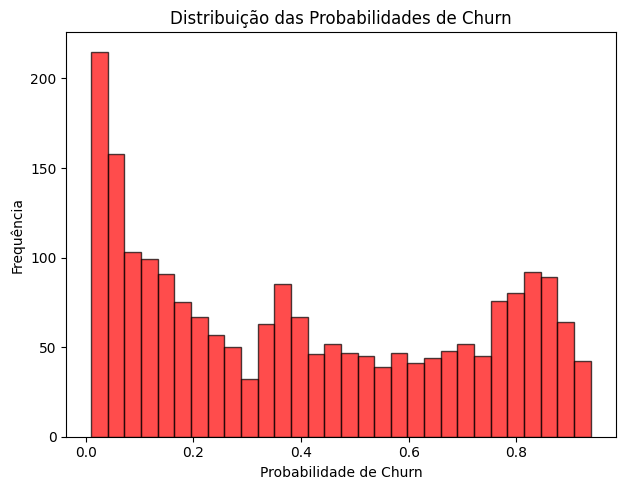

In [39]:
print("\n📊 Estatísticas das Previsões:")
print(f"Total de clientes previstos: {len(previsoes)}")
print(f"Clientes previstos com Churn: {previsoes.sum()} ({previsoes.sum()/len(previsoes)*100:.1f}%)")
print(f"Clientes previstos sem Churn: {len(previsoes) - previsoes.sum()} ({(1 - previsoes.sum()/len(previsoes))*100:.1f}%)")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(probabilidades[:, 1], bins=30, alpha=0.7, color='red', edgecolor='black')
plt.title('Distribuição das Probabilidades de Churn')
plt.xlabel('Probabilidade de Churn')
plt.ylabel('Frequência')

#plt.subplot(1, 2, 2)
#plt.boxplot(probabilidades[:, 1])
#plt.title('Boxplot das Probabilidades de Churn')
#plt.ylabel('Probabilidade')

plt.tight_layout()
plt.show()

In [38]:
# Se quiser testar com diferentes thresholds
thresholds_test = [0.3, 0.4, 0.5, 0.6]

for threshold in thresholds_test:
    previsoes_custom = (probabilidades[:, 1] >= threshold).astype(int)
    print(f"\n📈 Threshold {threshold}:")
    print(f"Churn previstos: {previsoes_custom.sum()} ({previsoes_custom.sum()/len(previsoes_custom)*100:.1f}%)")
    print(f"F1-Score: {f1_score(y_test, previsoes_custom):.3f}")


📈 Threshold 0.3:
Churn previstos: 1180 (55.9%)
F1-Score: 0.590

📈 Threshold 0.4:
Churn previstos: 967 (45.8%)
F1-Score: 0.616

📈 Threshold 0.5:
Churn previstos: 812 (38.5%)
F1-Score: 0.629

📈 Threshold 0.6:
Churn previstos: 670 (31.7%)
F1-Score: 0.635
